In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import beta
from scipy.sparse.linalg import lsqr
from scipy.optimize import nnls, minimize
from tephra2utils import io, vis
from time import process_time
from functools import reduce

In [2]:
#savefile tag

config = {}
with open("multi_phi_config.txt") as f:
    for line in f:
        (key, val) = line.split()
        config[str(key)] = float(val)
        
config["WIND_SPEED"] = 10

config["COL_STEPS"] = int(config["COL_STEPS"])
config["PART_STEPS"] = int(config["PART_STEPS"])

globs = {
    "LITHIC_DIAMETER_THRESHOLD": 7.,
    "PUMICE_DIAMETER_THRESHOLD": -1.,
    "AIR_VISCOSITY": 0.000018325,
    "AIR_DENSITY":  1.293,
    "GRAVITY": 9.81,
}

    
display(config)
display(globs)

{'VENT_EASTING': 0.0,
 'VENT_NORTHING': 0.0,
 'VENT_ELEVATION': 1.0,
 'PLUME_HEIGHT': 30000.0,
 'ALPHA': 3.0,
 'BETA': 2.0,
 'ERUPTION_MASS': 10000000000.0,
 'MAX_GRAINSIZE': -3.0,
 'MIN_GRAINSIZE': 3.0,
 'MEDIAN_GRAINSIZE': 0.0,
 'STD_GRAINSIZE': 1.0,
 'EDDY_CONST': 0.04,
 'DIFFUSION_COEFFICIENT': 1000000000.0,
 'FALL_TIME_THRESHOLD': 6000.0,
 'LITHIC_DENSITY': 2700.0,
 'PUMICE_DENSITY': 1024.0,
 'COL_STEPS': 200,
 'PART_STEPS': 5,
 'PLUME_MODEL': 2.0,
 'WIND_SPEED': 10}

{'LITHIC_DIAMETER_THRESHOLD': 7.0,
 'PUMICE_DIAMETER_THRESHOLD': -1.0,
 'AIR_VISCOSITY': 1.8325e-05,
 'AIR_DENSITY': 1.293,
 'GRAVITY': 9.81}

In [3]:
def pdf_grainsize(part_mean, part_sigma, part_max_grainsize, part_step_width):
    temp1 = 1.0 / (2.506628 * part_sigma)
    temp2 = np.exp(-(part_max_grainsize - part_mean)**2 / (2*part_sigma*part_sigma))
    func_rho = temp1 * temp2 * part_step_width
    return func_rho

def get_phi_steps(min_grainsize, max_grainsize, part_steps, median_grainsize, std_grainsize, lithic_diameter_threshold, pumice_diameter_threshold, lithic_density, pumice_density):
    part_section_width = min_grainsize - max_grainsize
    part_step_width = part_section_width / part_steps
    
    phi_steps = []

    y = max_grainsize
    for i in range(part_steps):
        if y > lithic_diameter_threshold:
            particle_density = lithic_density
        elif y < pumice_diameter_threshold:
            particle_density = pumice_density
        else:
            particle_density = lithic_density - (lithic_density - pumice_density) * (y - lithic_diameter_threshold)/(pumice_diameter_threshold - lithic_diameter_threshold)
        
        prob = pdf_grainsize(median_grainsize, std_grainsize, y, part_step_width)
        
        phi_class = {
            "lower": y,
            "upper": y + part_step_width,
            "interval": "[%.1f->%.1f)"%(y, y + part_step_width),
            "centroid": (y + (y + part_step_width))/2,
            "density":particle_density, 
            "probability": prob
        }
        phi_steps.append(phi_class)
        y += part_step_width
        
    return phi_steps

In [4]:
def sample(df, n, weight="MassArea", alpha=0.5):
    weights = df[weight].copy() # Get values to be used as weights
    weights = weights**(alpha) # Apply scaling factor as w^alpha
    probs = weights/np.sum(weights) # Normalise to sum up to one
    chosen = np.random.choice(df.index, n, replace=False, p=probs) # Randomly choose n points
    return df.loc[chosen]

In [5]:
def d2phi(d):
    return - np.log2(d)

def phi2d(phi):
    return 2**(-phi)

def column_spread_fine(height):
    return (0.2*(height**2))**(2/5)

def column_spread_coarse(height, diffusion_coefficient):
    return 0.0032 * (height**2) / diffusion_coefficient

def fall_time(terminal_velocity, release_height):
    return release_height/terminal_velocity

def func2(x, y, sigma_sqr, x_bar, y_bar):
    return 1/(2*np.pi*sigma_sqr) * np.exp(-((x - x_bar)**2 + (y - y_bar)**2)/(2*sigma_sqr))

def func(x, y, sigma_sqr, x_bar, y_bar):
    return 1/(np.pi*sigma_sqr) * np.exp(-((x - x_bar)**2 + (y - y_bar)**2)/(sigma_sqr))


def sigma_squared(height, fall_time, diff_coef, eddy_const, fall_time_thres):
    if fall_time < fall_time_thres:
        spread = column_spread_coarse(height, diff_coef)
        ss = 4*diff_coef*(fall_time + spread)
    else:
        spread = column_spread_fine(height)
        ss = ((8*eddy_const)/5) * ((fall_time + spread)**(5/2))
    if ss <=0:
        ss += 1e-9
    return ss

def landing_point(x1, z1, ux, vt):
    m = vt/ux
    return x1 - (z1/m)

def mass_dist_in_plume(dist, z_min, z_max, z_points, total_mass):
    z_norm = z_points/(z_max - z_min)
    pdf = dist.pdf(z_norm)
    pdf_sum = sum(dist.pdf(z_norm))
    norm_dist = dist.pdf(z_norm)/pdf_sum
    mass_dist = norm_dist * total_mass
    return mass_dist

def construct_dataframe(deposit, easting, northing):
    df = pd.DataFrame(deposit.T, columns=northing, index=easting)
    df.reset_index(inplace=True)
    #display(df)
    df = pd.melt(df, id_vars=["index"])
    df = df.rename(columns={"index": "Easting", "variable": "Northing", "value":"MassArea"})
    return df

def random_sample(n, df, sample_dev, K):
    transect = df[df["Northing"]==0].values
    max_point = np.argmax(transect)
    samp_x = df["Easting"].values
    return samp_x, samp_y

def part_fall_time(particle_ht, layer, ashdiam, part_density, air_density, gravity, air_viscosity):
    hz = particle_ht # height of particle above sea level
    particle_fall_time = 0.0
    
    # rho is the density of air (kg/m^3) at the elevation of the current particle
    rho = air_density * np.exp(-hz/8200.0) 
    
    #  (friction due to the air) :
    #  vtl is terminal velocity (m/s) in laminar regime RE<6
    #  vti is terminal velocity (m/s) in intermediate regime 6<RE<500
    #  vtt is terminal velocity (m/s) in turbulent regime RE>500
    
    vtl = part_density * gravity * ashdiam * ashdiam / (air_viscosity * 18.0)
    
    reynolds_number = ashdiam * rho * vtl / air_viscosity
    particle_term_vel = vtl
    temp0 = ashdiam * rho
    
    if reynolds_number >= 6.0:
        temp1 = 4.0 * gravity * gravity * part_density * part_density / (air_viscosity * 225.0 * rho)
        vti = ashdiam * (temp1 ** (1./3.)) 
        reynolds_number = temp0 * vti / air_viscosity
        particle_term_vel = vti

    # c...if intermediate RE>500 (turbulent regime), RE is calculated again considering vtt

    if reynolds_number >= 500.0:
        vtt = np.sqrt( 3.1 * part_density * gravity * ashdiam / rho)
        reynolds_number =  temp0 * vtt / air_viscosity
        particle_term_vel = vtt
    
    particle_fall_time = layer / particle_term_vel

    return (particle_fall_time, particle_term_vel)

def strat_average(average_wind_direction, average_windspeed, xspace, yspace, total_fall_time, sigma):
    temp0 = np.cos(average_wind_direction)
    temp1 = np.sin(average_wind_direction)

    xprime = xspace * temp0 + yspace * temp1
    yprime = yspace * temp0 - xspace * temp1

    temp0 = xprime - average_windspeed * total_fall_time
    demon1 = temp0 * temp0 + yprime * yprime
    demon3 = np.exp(-demon1/sigma) # where sigma is calculated for the total fall time 
    
    return demon3

In [6]:
def gaussian_stack_forward(config, globs, p, z_min, z_max, q_dist, tot_mass, u, phi, particle_density):
    # Release points in column
    layer_thickness = (z_max/p)
    z = np.linspace(z_min + layer_thickness, z_max, p)
    
    d = phi2d(phi)/1000
    vv = [-part_fall_time(zk, layer_thickness, 
                          d, particle_density, 
                          globs["AIR_DENSITY"], 
                          globs["GRAVITY"], 
                          globs["AIR_VISCOSITY"])[1] for zk in z]
    ft = [part_fall_time(zk, layer_thickness, d, particle_density, globs["AIR_DENSITY"], globs["GRAVITY"], globs["AIR_VISCOSITY"])[0] for zk in z]
    
    
    # Landing points of release point centers {DEPRECATED}
    x_bar = [landing_point(0, zk, u, v) for zk, v in zip(z, vv)]

    #Mass distribution in the plume
    q_mass = mass_dist_in_plume(q_dist, z_min, z_max, z, tot_mass)
    
    q = q_mass
    
    input_data = np.asarray([z, np.asarray(q_mass), np.asarray(q), np.asarray(x_bar)]).T
    input_table = pd.DataFrame(input_data,  columns=["Release Height (z)", 
                                                     "Suspended Mass (q)", 
                                                     "Scaled Mass (q)", 
                                                     "Landing Points (x_bar)"])
    
    xx = np.linspace(-200000, 300000, 501)
    x_range = xx[-1] - xx[0]
    yy = np.linspace(-250000, 250000, 501)
    X, Y = np.meshgrid(xx, yy)
    dep_mass = np.zeros(X.shape)
    sus_mass = []
    sig = []

    for k, zh in enumerate(z):
        # Gaussian dispersal
        s_sqr = sigma_squared(zh, sum(ft[:k+1]), 
                              config["DIFFUSION_COEFFICIENT"], 
                              config["EDDY_CONST"], 
                              config["FALL_TIME_THRESHOLD"])
        dist = strat_average(0, u, X, Y, sum(ft[:k+1]), s_sqr)
        
        dep_mass += (q[k]/(s_sqr*np.pi))*dist
        sig.append(s_sqr)
    dep_df = construct_dataframe(dep_mass, xx, yy)   
    return input_table, dep_df, sig, vv, ft

In [7]:
def beta_function(z, a, b, h0, h1):
    return beta.pdf(z, a, b, h0, h1)

def beta_transform(a_star, b_star, h0_star, h1_star, tot_mass, z):
    a, b, h0, h1 = param_transform(a_star, b_star, h0_star, h1_star)
#     a = np.exp(a_star)
#     b = np.exp(b_star)
#     h1 = 45000*np.exp(-np.exp(-h1_star))
#     h0 = h1*np.exp(-np.exp(-h0_star))
    dist = beta.pdf(z, a, b, h0, h1)
    return (dist/sum(dist))*tot_mass

def param_transform(a_star, b_star, h0_star, h1_star):
    a = np.exp(a_star) + 1
    b = np.exp(b_star) + 1
    h1 = 45000*np.exp(-np.exp(-h1_star))
    h0 = h1*np.exp(-np.exp(-h0_star))
    return a, b, h0, h1

def beta_sse(k, A, z, m, tot_mass):
     return sum((np.matmul(A, beta_transform(*k, tot_mass, z)) - m) ** 2)

def phi_sse(k, params, z):
    tot_sum = 0
    for par in params:
        A, m, phi_mass = par
        beta_sum = beta_sse(k, A, z, m, phi_mass)
        tot_sum += beta_sum
    return tot_sum


def gaussian_stack_inversion(config, globs, samp_df, n, p, z_min, z_max, tot_mass, u, phi_steps, solver=None):
    # Release points in column

    layer_thickness = (z_max/p)
    z = np.linspace(z_min + layer_thickness, z_max, p)
    params = []
    for phi_step in phi_steps:
        d = phi2d(phi_step["lower"])/1000
        vv = [-part_fall_time(zk, layer_thickness, d, phi_step["density"], 
                              globs["AIR_DENSITY"], 
                              globs["GRAVITY"], 
                              globs["AIR_VISCOSITY"])[1] for zk in z]
        ft = [part_fall_time(zk, layer_thickness, d, phi_step["density"], 
                              globs["AIR_DENSITY"], 
                              globs["GRAVITY"], 
                              globs["AIR_VISCOSITY"])[0] for zk in z]

        # Landing points of release point centers
        x_bar = [landing_point(0, zk, u, vv[i]) for i, zk in enumerate(z)]

        samp_x = samp_df['Easting'].values
        samp_y = samp_df["Northing"].values
        m = samp_df["MassArea"].values * (samp_df[phi_step["interval"]].values / 100)

        A = np.zeros((n,p))
        for i in range(n):
            for k in range(p):
                s_sqr = sigma_squared(z[k], sum(ft[:k+1]), 
                                      config["DIFFUSION_COEFFICIENT"], 
                                      config["EDDY_CONST"], 
                                      config["FALL_TIME_THRESHOLD"])
                dist = strat_average(0, u, samp_x[i], samp_y[i], sum(ft[:k+1]), s_sqr)
                A[i,k] = (1/(s_sqr*np.pi))*dist
        coefficient_matrix = pd.DataFrame(A)
        if n == p:
            det = np.linalg.det(A)
        else: 
            det = None
        rank = np.linalg.matrix_rank(A)
        phi_mass = tot_mass * phi_step["probability"]
        params.append([A, m, phi_mass])
    
    if solver=='lsqr':
        lst_q = lsqr(A, m, damp=1e-10)
        q_inv_mass = np.asarray(lst_q[0])
    else:
        k0 = np.array([1, 1, 1, 1], dtype=np.float64)
        def func(k): return phi_sse(k, params, z)
        sol = minimize(func, k0, method='Nelder-Mead')
        params = param_transform(*sol.x)
        print("a* = %.5f\tb* = %.5f\th0* = %.5f\th1* = %.5f"%(sol.x[0], sol.x[1], sol.x[2], sol.x[3]))
        print("a = %.5f\tb = %.5f\th0 = %.5f\th1 = %.5f"%params)
        print("Success: " + str(sol.success) + ", " + str(sol.message))
        if(hasattr(sol, "nit")):
            print("Iterations: " + str(sol.nit))
        q_inv_mass = beta_transform(*sol.x, tot_mass, z)
    
    inversion_data = np.asarray([np.asarray(z), q_inv_mass]).T
    inversion_table = pd.DataFrame(inversion_data, columns=["Height", "Suspended Mass"])
    return inversion_table, coefficient_matrix, det, rank

[{'lower': -3.0,
  'upper': -1.8,
  'interval': '[-3.0->-1.8)',
  'centroid': -2.4,
  'density': 1024.0,
  'probability': 0.005318218676999845},
 {'lower': -1.8,
  'upper': -0.6000000000000001,
  'interval': '[-1.8->-0.6)',
  'centroid': -1.2000000000000002,
  'density': 1024.0,
  'probability': 0.094740200340991},
 {'lower': -0.6000000000000001,
  'upper': 0.5999999999999999,
  'interval': '[-0.6->0.6)',
  'centroid': -1.1102230246251565e-16,
  'density': 1107.8000000000002,
  'probability': 0.3998695672806361},
 {'lower': 0.5999999999999999,
  'upper': 1.7999999999999998,
  'interval': '[0.6->1.8)',
  'centroid': 1.1999999999999997,
  'density': 1359.1999999999998,
  'probability': 0.39986956728063616},
 {'lower': 1.7999999999999998,
  'upper': 3.0,
  'interval': '[1.8->3.0)',
  'centroid': 2.4,
  'density': 1610.6,
  'probability': 0.09474020034099104}]

<IPython.core.display.Javascript object>


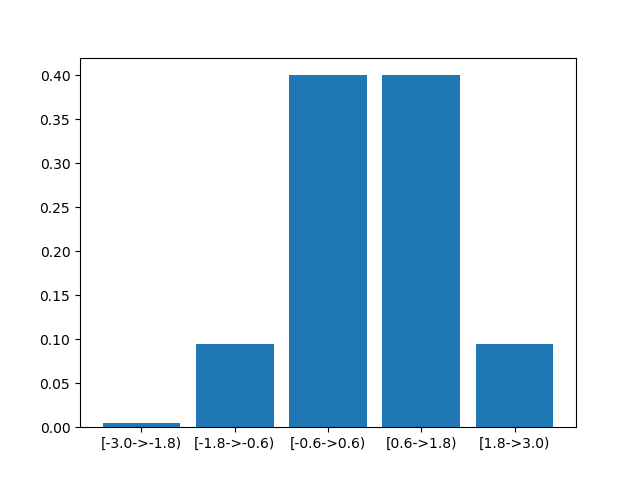

In [8]:
phi_steps = get_phi_steps(config["MIN_GRAINSIZE"], config["MAX_GRAINSIZE"], config["PART_STEPS"], 
              config["MEDIAN_GRAINSIZE"], config["STD_GRAINSIZE"],
              globs["LITHIC_DIAMETER_THRESHOLD"], globs["PUMICE_DIAMETER_THRESHOLD"], 
              config["LITHIC_DENSITY"], config["PUMICE_DENSITY"])
step_width = (config["MAX_GRAINSIZE"] - config["MIN_GRAINSIZE"])/config["PART_STEPS"]

display(phi_steps)

probs = [phi["probability"] for phi in phi_steps]
x = [phi["centroid"] for phi in phi_steps]
labels = [phi["interval"] for phi in phi_steps]
fig, ax = plt.subplots()
ax.bar(x, probs, width=1, align="center")
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.show()

In [9]:
t = process_time()
t_tot = process_time()
df_list = []
for phi_step in phi_steps:
    q_dist = beta(config["ALPHA"],config["BETA"])


    mass_in_phi = config["ERUPTION_MASS"] * phi_step["probability"]

    input_table, gsm_df, sig, vv, tft= gaussian_stack_forward(config, globs, 
                                                          int(config["COL_STEPS"]), 0, 
                                                          config["PLUME_HEIGHT"], 
                                                          q_dist,
                                                          mass_in_phi, 
                                                          config["WIND_SPEED"], 
                                                          phi_step["lower"], 
                                                          phi_step["density"])
    df_list.append(gsm_df.rename(columns={"MassArea":phi_step["interval"]}))
elapsed_time = process_time() - t
print("Forward Sim time: %.5f seconds"%elapsed_time)



t = process_time()
df_merge = reduce(lambda x, y: pd.merge(x, y, on =['Northing', 'Easting']), df_list)
elapsed_time = process_time() - t
print("Dataframe Merge time: %.5f seconds"%elapsed_time)



t = process_time()
# THIS IS SLOOOOOW. maybe native python mapping is faster? 
df_merge["MassArea"] = df_merge.apply(lambda row: sum(row[labels].values), axis=1) # This is the slow one
elapsed_time = process_time() - t
print("Tot M/A calc time: %.5f seconds"%elapsed_time)

t = process_time()
for label in labels:
    df_merge[label] = df_merge.apply(lambda row: (row[label]/row["MassArea"])*100, axis=1) # This operation is much faster
    
elapsed_time = process_time() - t
print("Phi Wt perc calc time: %.5f seconds"%elapsed_time)

total_time = process_time() - t_tot
print("Total time: %.5f seconds"%total_time)
display(df_merge)

Forward Sim time: 15.55439 seconds
Dataframe Merge time: 0.91263 seconds
Tot M/A calc time: 128.14525 seconds
Phi Wt perc calc time: 18.28411 seconds
Total time: 162.89766 seconds


,Easting,Northing,[-3.0->-1.8),[-1.8->-0.6),[-0.6->0.6),[0.6->1.8),[1.8->3.0),MassArea
0,-200000.0,-250000,1.606627,19.155165,51.807445,26.402882,1.027881,0.000361
1,-199000.0,-250000,1.606777,19.155896,51.807510,26.401979,1.027838,0.000361
2,-198000.0,-250000,1.606927,19.156623,51.807575,26.401080,1.027795,0.000361
3,-197000.0,-250000,1.607075,19.157347,51.807639,26.400186,1.027753,0.000361
4,-196000.0,-250000,1.607223,19.158067,51.807702,26.399296,1.027711,0.000361
5,-195000.0,-250000,1.607371,19.158784,51.807766,26.398411,1.027669,0.000361
6,-194000.0,-250000,1.607517,19.159496,51.807829,26.397530,1.027627,0.000361
7,-193000.0,-250000,1.607663,19.160206,51.807891,26.396654,1.027586,0.000361
8,-192000.0,-250000,1.607808,19.160911,51.807954,26.395782,1.027544,0.000361
9,-191000.0,-250000,1.607953,19.161614,51.808016,26.394915,1.027503,0.000361


In [10]:
threshold = 10e-5

df = df_merge[df_merge["MassArea"] > threshold]
df = df[df["Easting"] < 200000]
df = df[df["Easting"] > -20000]
df = df[df["Northing"] < 100000]
df = df[df["Northing"] > -100000]

piv = df.pivot("Northing", "Easting", "MassArea")

219


<IPython.core.display.Javascript object>


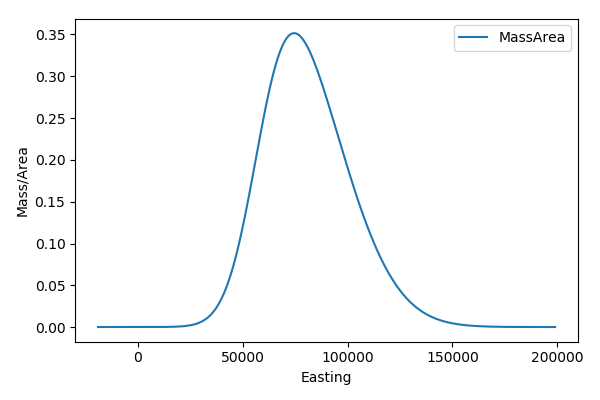

In [11]:
transect = df[df["Northing"]==0]
print(len(transect))

fig, ax1= plt.subplots(1,1, figsize=(
        6, 4), facecolor='w', edgecolor='k')



ax1.plot(transect["Easting"], transect["MassArea"])
ax1.legend()
ax1.set_xlabel("Easting")
ax1.set_ylabel("Mass/Area")
plt.tight_layout()
plt.show()


array([162191, 173119, 132082, 124935, 156115, 103518, 131998, 110470,
       104965, 119066, 164114, 129626,  90444,  99531, 146065, 103011,
       118484, 101464, 140051,  96473, 127021,  88432, 147536, 132137,
       116989, 142585, 111474, 151083, 143629, 140075])

<IPython.core.display.Javascript object>


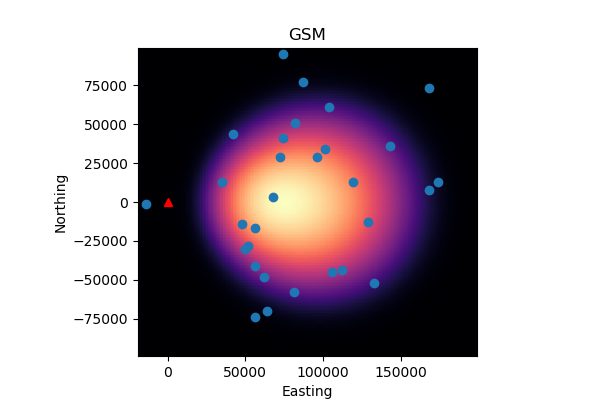

In [14]:
n=30

lower_lim = np.nanmin(piv.values)
upper_lim = np.nanmax(piv.values)

sample_pts = sample(df, n, alpha=.3).copy()
display(sample_pts.index.values)


fig, ax1 = plt.subplots(1,1, figsize=(
        6, 4), facecolor='w', edgecolor='k')


im1 = ax1.imshow(np.log10(piv.values),
                 extent=[piv.columns.min(), piv.columns.max(),
                       piv.index.min(), piv.index.max()],
                 origin='lower',
                 cmap="magma", alpha=1,
                 vmin=np.log10(lower_lim),
                 vmax=np.log10(upper_lim))

ax1.scatter(sample_pts["Easting"], sample_pts["Northing"])
ax1.plot(0,0,"r^")
ax1.set_xlabel("Easting")
ax1.set_ylabel("Northing")
ax1.set_title("GSM")


plt.show()

GSM
a* = 0.69315	b* = 0.00000	h0* = -107.30659	h1* = 0.90272
a = 3.00000	b = 2.00000	h0 = 0.00000	h1 = 30000.00101
Success: True, Optimization terminated successfully.
Iterations: 332


<IPython.core.display.Javascript object>


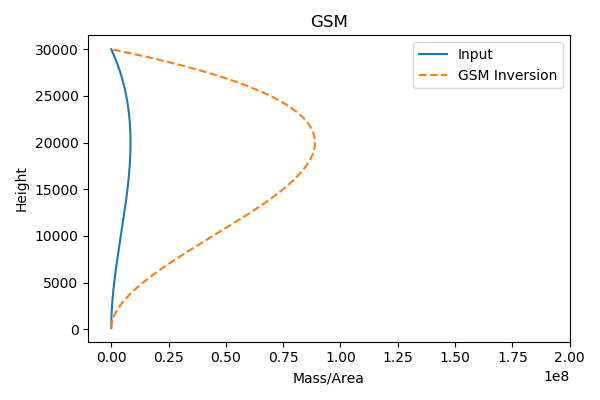

In [13]:
print("GSM")
inversion_table_gsm, _, _, _ = gaussian_stack_inversion(config, globs, sample_pts, n, 
                                                          int(config["COL_STEPS"]), 0, 
                                                          config["PLUME_HEIGHT"], 
                                                          config["ERUPTION_MASS"], 
                                                          config["WIND_SPEED"],
                                                          phi_steps,
                                                          solver=None)




fig, ax1 = plt.subplots(1,1, figsize=(
        6, 4), facecolor='w', edgecolor='k')

ax1.plot(input_table["Suspended Mass (q)"], input_table["Release Height (z)"], label="Input")
ax1.plot(inversion_table_gsm["Suspended Mass"], inversion_table_gsm["Height"], '--', label="GSM Inversion")
ax1.legend()
ax1.set_title("GSM")
ax1.set_ylabel("Height")
ax1.set_xlabel("Mass/Area")


ax1.set_xlim([-10000000,2e8])

plt.tight_layout()
# plt.show()
# plt.savefig(tag + "_inversions.png", dpi=200, format='png')
